In [1]:
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp
import foscat.CircSpline as sc
import foscat.Spline1D as sc1d

In [2]:
def function(x,y,z):
    #data=(np.cos(x*nside*2)*np.sin(nside*1.3*y)*np.tanh(z*nside)).flatten()
    return x.flatten()

# Build scanning data

(1e-16, 10)

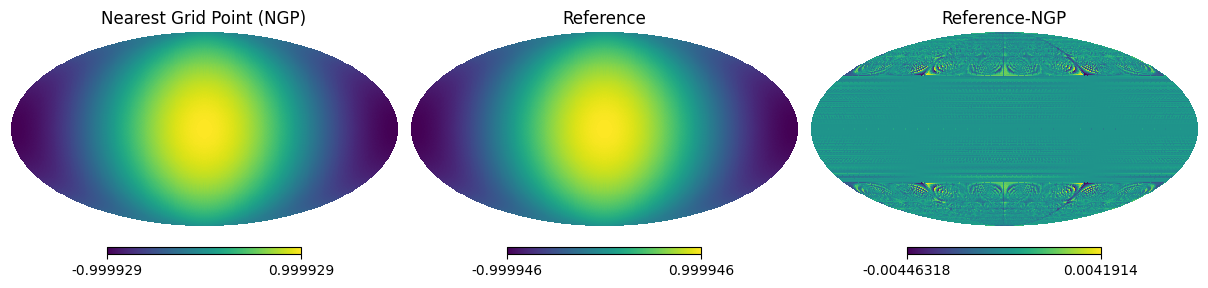

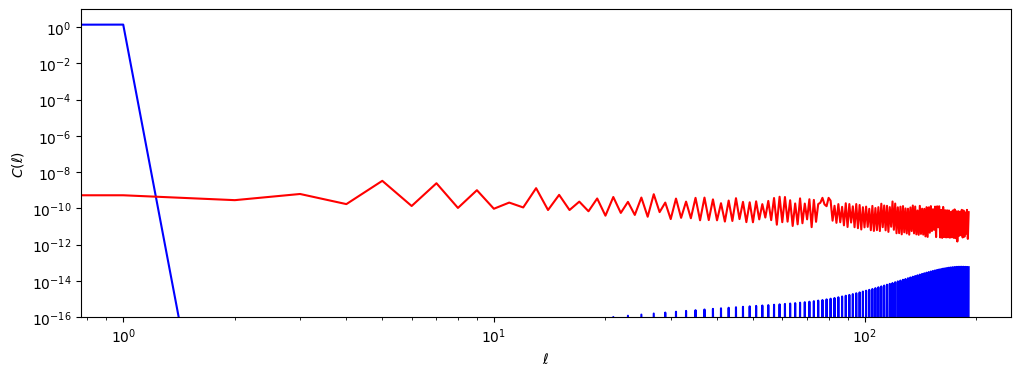

In [3]:
nside=64

#compute the scan over the poles
nscan=512
npt_in_scan=2048

alpha=np.arange(nscan)/nscan*(2*np.pi)
z=np.sin(np.arange(npt_in_scan)/(2*np.pi))[None,:]+0*alpha[:,None]
x=np.cos(alpha[:,None])*np.cos(np.arange(npt_in_scan)[None,:]/(2*np.pi))
y=np.sin(alpha[:,None])*np.cos(np.arange(npt_in_scan)[None,:]/(2*np.pi))

heal_idx=hp.vec2pix(nside,x,y,z).flatten()

#compute analytic values
data=function(x,y,z)

xr,yr,zr=hp.pix2vec(nside,np.arange(12*nside**2))
ref_map=function(xr,yr,zr)
hit_count=np.bincount(heal_idx,minlength=12*nside**2)
value=np.bincount(heal_idx,weights=data,minlength=12*nside**2)

ngp_map=value/hit_count
plt.figure(figsize=(12,4))
hp.mollview(ngp_map,hold=False,sub=(1,3,1),title='Nearest Grid Point (NGP)')
hp.mollview(ref_map,hold=False,sub=(1,3,2),title='Reference')
hp.mollview(ngp_map-ref_map,hold=False,sub=(1,3,3),title='Reference-NGP')


plt.figure(figsize=(12,4))
plt.plot(hp.anafast(ref_map),color='b',label='Reference')
plt.plot(hp.anafast(ref_map-ngp_map),color='r',label='Reference-NGP')
plt.xscale('log')
plt.yscale('log')
plt.ylabel(r'$C(\ell)$')
plt.xlabel(r'$\ell$')
plt.ylim(1E-16,10)

# Build spline weights

To compute the spline weights, we need to determine the *ring* index, which depends mainly on the colatitude, as stored in a HEALPix map.  
For efficiency  [*rg_indices*], we use:
- a precomputed array of the number of knots per ring (stored in a vector of length 4*nside - 1) [*n_ring*],
- and the index within each ring in longitude, defined as the distance to the minimum longitude knot in that ring [*ph0_indices*].

The next cell permanently precomputes these values, and the following cell applies them to the scan coordinates.

In [4]:
from scipy.interpolate import interp1d

th,ph=hp.pix2ang(nside,np.arange(12*nside**2))
u_th,ph0_indices, rg_indices = np.unique(th, return_inverse=True, return_index=True)
n_ring=np.bincount(rg_indices)
spline_table={}
for k in range(4*nside-1):
    spline_table[k]=sc.CircSpline(n_ring[k],3)
ph0_val=ph[ph0_indices]
th0_val=th[ph0_indices]

spline_lat=sc1d.Spline1D(4*nside-1,3)

#convert colatitude in ring index
f_interp_th = interp1d(np.concatenate([[0],(th0_val[:-1]+th0_val[1:])/2,[np.pi]],0),np.arange(4*nside)/(4*nside), kind='cubic', fill_value='extrapolate')
y_th = f_interp_th(th0_val)

In [5]:
www     = np.zeros([4,4,x.flatten().shape[0]])
all_idx = np.zeros([4,4,x.flatten().shape[0]],dtype='int')

th,ph=hp.vec2ang(np.concatenate([x.flatten()[:,None],
                                 y.flatten()[:,None],
                                 z.flatten()[:,None]],1))
th0   = f_interp_th(th)
idx_th,w_th=spline_lat.eval(th0)

for iring in range(len(spline_table)):
    for k in range(4):
        iii=np.where(idx_th[k]==iring)[0]
        idx,w=spline_table[iring].eval((ph[iii]-ph0_val[iring])/(2*np.pi))
        idx=idx+ph0_indices[iring]
        for m in range(4):
            www[k,m,iii]=w[m]*w_th[k,iii]
            all_idx[k,m,iii]=idx[m]

www=www.reshape(16,www.shape[2])
all_idx=all_idx.reshape(16,all_idx.shape[2])

# compute the wieght and idx to calculate the value at the center of healpix pixel

In [6]:
r_www     = np.zeros([4,4,12*nside**2])
r_all_idx = np.zeros([4,4,12*nside**2],dtype='int')

th,ph=hp.pix2ang(nside,np.arange(12*nside**2))
th0   = f_interp_th(th)
idx_th,w_th=spline_lat.eval(th0)

for iring in range(len(spline_table)):
    for k in range(4):
        iii=np.where(idx_th[k]==iring)[0]
        idx,w=spline_table[iring].eval((ph[iii]-ph0_val[iring])/(2*np.pi))
        idx=idx+ph0_indices[iring]
        for m in range(4):
            r_www[k,m,iii]=w[m]*w_th[k,iii]
            r_all_idx[k,m,iii]=idx[m]

r_www=r_www.reshape(16,r_www.shape[2])
r_all_idx=r_all_idx.reshape(16,r_all_idx.shape[2])

# compute the spline knots values

The concept is to use conjugate gradient computation to determine the value of each spline knots that minimize the difference with abserved data.

In [7]:
#P(x) should return a 1D NumPy array of shape (M,)

def P(x,www,all_idx):
    return np.sum(www*x[all_idx],0)
    
#PT(y) must return a 1D NumPy array of shape (N,)
def PT(y,www,all_idx):
    value=np.bincount(all_idx.flatten(),weights=(www*y[None,:]).flatten(),minlength=12*nside**2)
    hit=np.bincount(all_idx.flatten(),weights=(www).flatten(),minlength=12*nside**2)
    value[hit>0]/=hit[hit>0]
    return value
    

In [8]:
# the data is of dimension M
# the x is of dimension N=12*nside**2

def conjugate_gradient_normal_equation(P, PT, data, x0, max_iter=100, tol=1e-10, verbose=False):
    """
    Solve (PᵗP)x = Pᵗy using explicit Conjugate Gradient without scipy.cg.

    Parameters:
    ----------
    P       : function(x) → forward operator (ℝⁿ → ℝᵐ)
    PT      : function(y) → adjoint operator (ℝᵐ → ℝⁿ)
    data    : array_like, observed data y ∈ ℝᵐ
    x0      : array_like, initial guess for x ∈ ℝⁿ
    max_iter: maximum number of iterations
    tol     : convergence tolerance on relative residual
    verbose : if True, print convergence info

    Returns:
    -------
    x       : estimated solution ∈ ℝⁿ
    """
    x = x0.copy()
    
    # Compute b = Pᵗ y # This part could be distributed easily
    b = PT(data,www,all_idx)
    
    # Compute initial residual r = b - A x = b - Pᵗ P x
    Ax = PT(P(x,www,all_idx),www,all_idx)# This part could be distributed easily
    r = b - Ax
    # Initial direction
    p = r.copy()
    rs_old = np.dot(r, r)
    for i in range(max_iter):
        # Apply A p = Pᵗ P p
        Ap = PT(P(p,www,all_idx),www,all_idx)# This part could be distributed easily
        
        alpha = rs_old / np.dot(p, Ap)
        x += alpha * p
        r -= alpha * Ap

        rs_new = np.dot(r, r)
        
        if verbose and i%10==9:
            print(f"Iter {i:03d}: residual = {np.sqrt(rs_new):.3e}")

        if np.sqrt(rs_new) < tol:
            if verbose:
                print("Converged.")
            break

        p = r + (rs_new / rs_old) * p
        rs_old = rs_new

    return x

In [9]:
N = 12 * nside**2
x0 = ngp_map
x0[np.isnan(x0)]=0.0

x_opt = conjugate_gradient_normal_equation(P, PT, data, x0, max_iter=200, tol=1e-12, verbose=True)

Iter 009: residual = 1.046e-03
Iter 019: residual = 4.719e-04
Iter 029: residual = 1.341e-04
Iter 039: residual = 3.958e-05
Iter 049: residual = 1.774e-05
Iter 059: residual = 9.811e-06
Iter 069: residual = 5.705e-06
Iter 079: residual = 3.018e-06
Iter 089: residual = 1.667e-06
Iter 099: residual = 1.094e-06
Iter 109: residual = 6.393e-07
Iter 119: residual = 3.898e-07
Iter 129: residual = 2.695e-07
Iter 139: residual = 2.311e-07
Iter 149: residual = 2.269e-07
Iter 159: residual = 2.155e-07
Iter 169: residual = 1.882e-07
Iter 179: residual = 1.490e-07
Iter 189: residual = 1.166e-07
Iter 199: residual = 8.507e-08


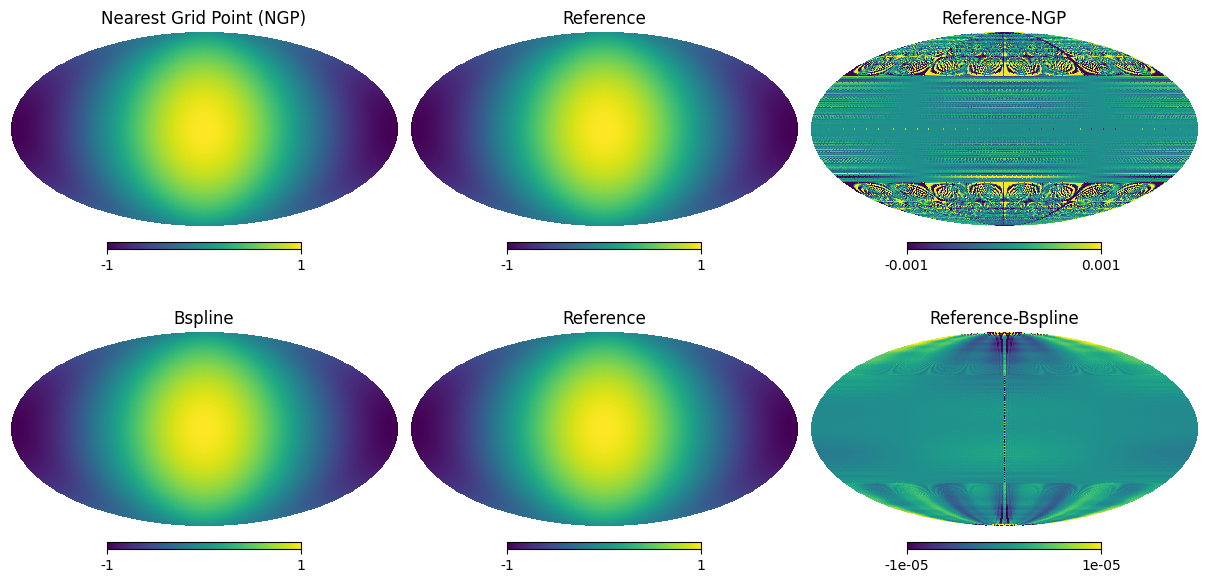

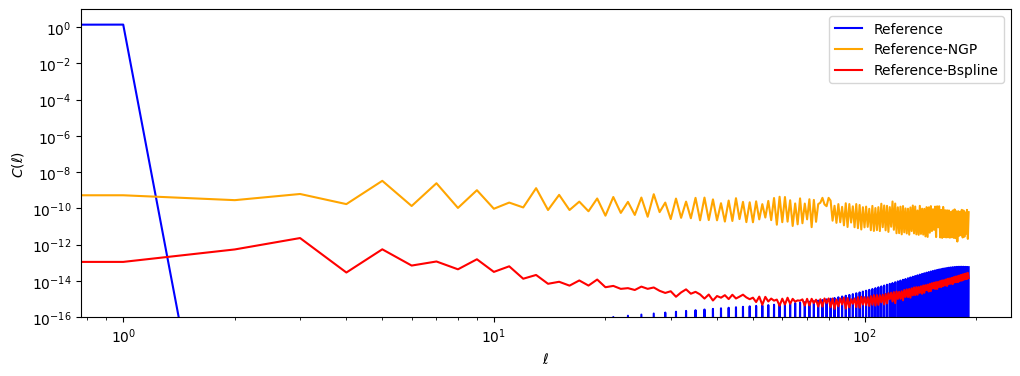

In [10]:
#compute the reference map
y=P(x_opt,r_www,r_all_idx)

amp=0.001
plt.figure(figsize=(12,6))
hp.mollview(ngp_map,hold=False,sub=(2,3,1),title='Nearest Grid Point (NGP)',min=-1,max=1)
hp.mollview(ref_map,hold=False,sub=(2,3,2),title='Reference',min=-1,max=1)
hp.mollview(ngp_map-ref_map,hold=False,sub=(2,3,3),title='Reference-NGP',min=-amp,max=amp)
hp.mollview(y,hold=False,sub=(2,3,4),title='Bspline',min=-1,max=1)
hp.mollview(ref_map,hold=False,sub=(2,3,5),title='Reference',min=-1,max=1)
hp.mollview(y-ref_map,hold=False,sub=(2,3,6),title='Reference-Bspline',min=-amp/100,max=amp/100)


plt.figure(figsize=(12,4))
plt.plot(hp.anafast(ref_map),color='b',label='Reference')
plt.plot(hp.anafast(ref_map-ngp_map),color='orange',label='Reference-NGP')
plt.plot(hp.anafast(ref_map-y),color='r',label='Reference-Bspline')
plt.xscale('log')
plt.yscale('log')
plt.ylabel(r'$C(\ell)$')
plt.xlabel(r'$\ell$')
plt.ylim(1E-16,10)
plt.legend()

# check the reprojection consistency

In [11]:
rdata=ngp_map[heal_idx]
ldata=P(x_opt,www,all_idx)

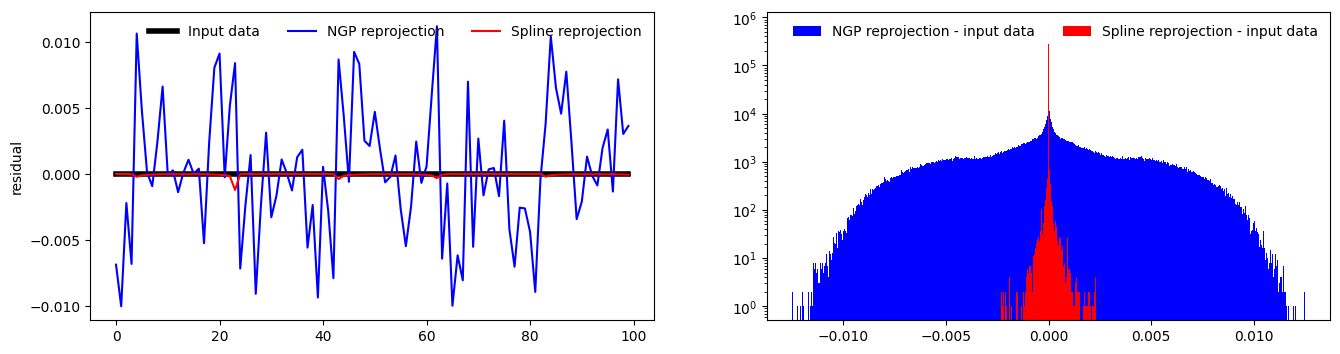

In [12]:
plt.figure(figsize=(16,4))
plt.subplot(1,2,1)
plt.plot(data[500:600]-data[500:600],color='black',lw=4,label='Input data')
plt.plot(rdata[500:600]-data[500:600],color='b',label='NGP reprojection')
plt.plot(ldata[500:600]-data[500:600],color='r',label='Spline reprojection')
plt.legend(frameon=0,ncol=3,loc=1)
plt.ylabel('residual')
#plt.ylim(-1.2,1.4)
plt.subplot(1,2,2)
plt.hist(rdata-data,color='b',label='NGP reprojection - input data',bins=1000)
plt.hist(ldata-data,color='r',label='Spline reprojection - input data',bins=1000)
plt.legend(frameon=0,ncol=2)
plt.yscale('log')

# add noise to check the performences

In [13]:

value=np.bincount(heal_idx,weights=data+1E-2*np.random.randn(data.shape[0]),minlength=12*nside**2)
ngp_map2=value/hit_count

x_opt = conjugate_gradient_normal_equation(P, PT, data+1E-2*np.random.randn(data.shape[0]), x0, max_iter=200, tol=1e-12, verbose=True)

Iter 009: residual = 1.954e-02
Iter 019: residual = 3.739e-03
Iter 029: residual = 1.141e-03
Iter 039: residual = 4.067e-04
Iter 049: residual = 1.408e-04
Iter 059: residual = 5.226e-05
Iter 069: residual = 1.851e-05
Iter 079: residual = 7.232e-06
Iter 089: residual = 2.727e-06
Iter 099: residual = 1.503e-06
Iter 109: residual = 1.313e-06
Iter 119: residual = 1.079e-06
Iter 129: residual = 5.163e-07
Iter 139: residual = 2.028e-07
Iter 149: residual = 7.907e-08
Iter 159: residual = 3.109e-08
Iter 169: residual = 1.280e-08
Iter 179: residual = 4.987e-09
Iter 189: residual = 1.864e-09
Iter 199: residual = 7.206e-10


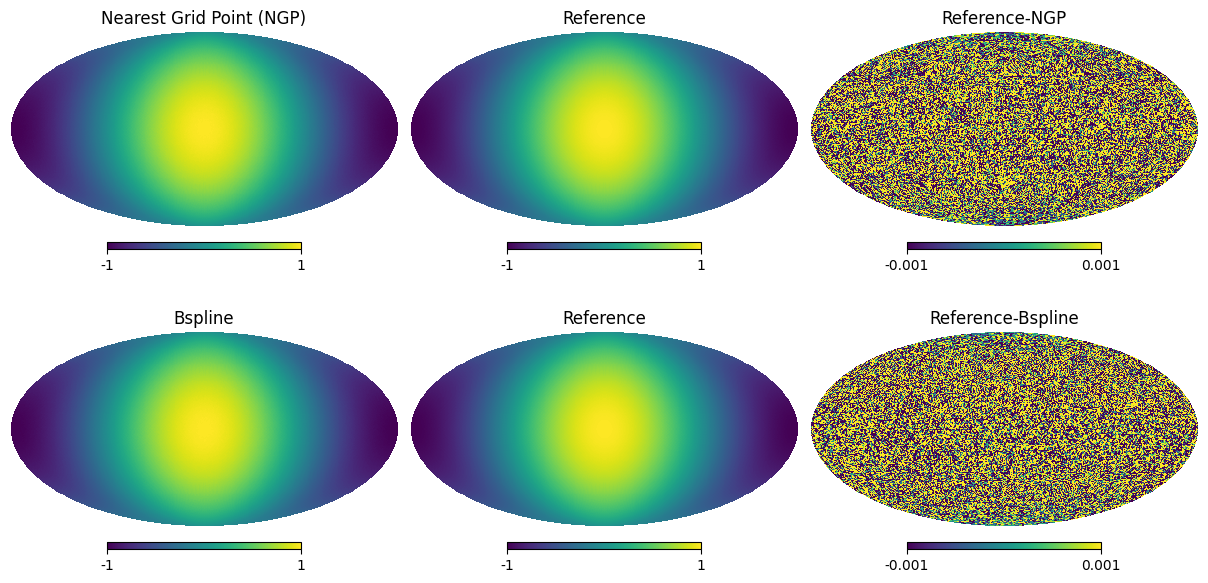

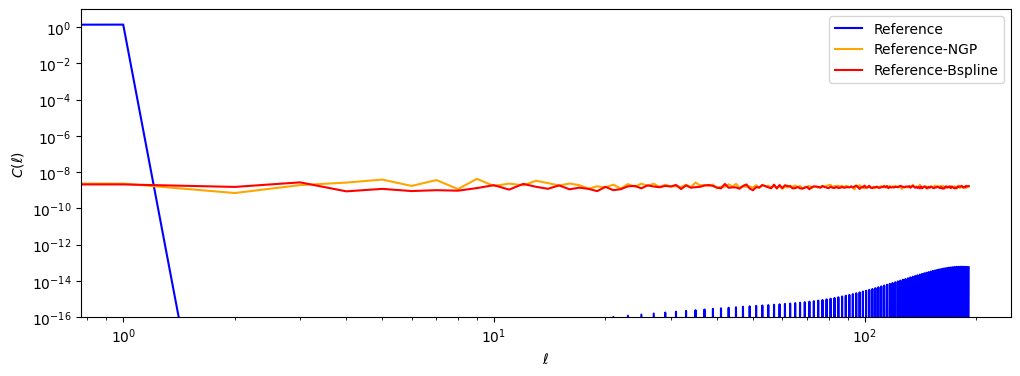

In [14]:
#compute the reference map
y=P(x_opt,r_www,r_all_idx)

amp=0.001
plt.figure(figsize=(12,6))
hp.mollview(ngp_map2,hold=False,sub=(2,3,1),title='Nearest Grid Point (NGP)',min=-1,max=1)
hp.mollview(ref_map,hold=False,sub=(2,3,2),title='Reference',min=-1,max=1)
hp.mollview(ngp_map2-ref_map,hold=False,sub=(2,3,3),title='Reference-NGP',min=-amp,max=amp)
hp.mollview(y,hold=False,sub=(2,3,4),title='Bspline',min=-1,max=1)
hp.mollview(ref_map,hold=False,sub=(2,3,5),title='Reference',min=-1,max=1)
hp.mollview(y-ref_map,hold=False,sub=(2,3,6),title='Reference-Bspline',min=-amp,max=amp)


plt.figure(figsize=(12,4))
plt.plot(hp.anafast(ref_map),color='b',label='Reference')
plt.plot(hp.anafast(ref_map-ngp_map2),color='orange',label='Reference-NGP')
plt.plot(hp.anafast(ref_map-y),color='r',label='Reference-Bspline')
plt.xscale('log')
plt.yscale('log')
plt.ylabel(r'$C(\ell)$')
plt.xlabel(r'$\ell$')
plt.ylim(1E-16,10)
plt.legend()